In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error



In [2]:
path = '/Users/sheenmccullough/Documents/Kaggle/M5Forecasting/'

calendar = pd.read_csv(path+'calendar.csv')
trainData = pd.read_csv(path+'sales_train_validation.csv')
sellprices = pd.read_csv(path+'sell_prices.csv')

In [3]:
def Convert_to_transaction(df):
    
    '''
    convert our sales data into a daily transacitons set using the pandas melt function
    '''
    list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
    d_columns = df.drop(list_id_vars,axis=1)
    df_melted_sales = df.melt(id_vars = list_id_vars, value_vars = d_columns.columns, var_name = 'days', value_name = 'sales') 
    
    
    return df_melted_sales



In [4]:
# This usually takes 16-19 sec to run

train_df_melt = Convert_to_transaction(trainData)

In [5]:
#del train_df_melt
del trainData
gc.collect()

144

In [6]:
train_df_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
train_df = pd.merge(train_df_melt,calendar[['d','wday','wm_yr_wk','event_name_1','date','year']],left_on='days',
                    right_on='d')

In [8]:
texas = train_df[train_df['state_id']=='TX']

In [9]:
daily_sales = texas.groupby(['date'])['sales'].sum()

### basic time series equation

$$ Sales_{t+1} = f(Sales_t,Sales_{t-1},Sales_{t-2},Sales_{t-3}....,error), $$
#### Where t+1 is the next day and t-1 is the previous day. T-2 is two days prior and so on..This simplistic model's future prediction is only based on past sales values, but not on any external variables which might affect sales. The error term on the right allows for random variation

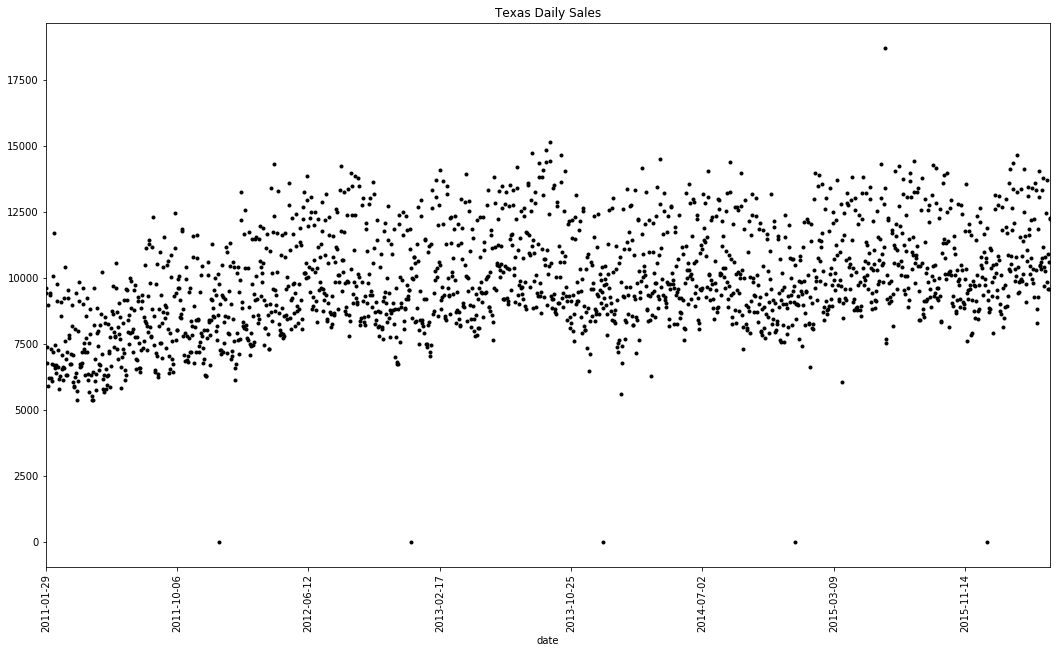

In [10]:
## texas daily sales
plt.title('Texas Daily Sales')
daily_sales.plot(style='k.',figsize=(18,10))
plt.xticks(rotation='vertical')
plt.show()


## seasonal plot

In [11]:
def seasonalplot(df):
    
    data=df[['year','date','sales']]
    unique_yrs = list(data['year'].drop_duplicates())
    for y in unique_yrs:
        yr_df = data[data['year']==y]
        yr_df['Month'] =pd.DatetimeIndex( yr_df['date']).month
        grpd = yr_df.groupby(['Month'])['sales'].sum()
        grpd.plot(figsize=(18,10))
    
    plt.legend(unique_yrs,fontsize=12,loc='upper left')
    plt.show()
    
        
    

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

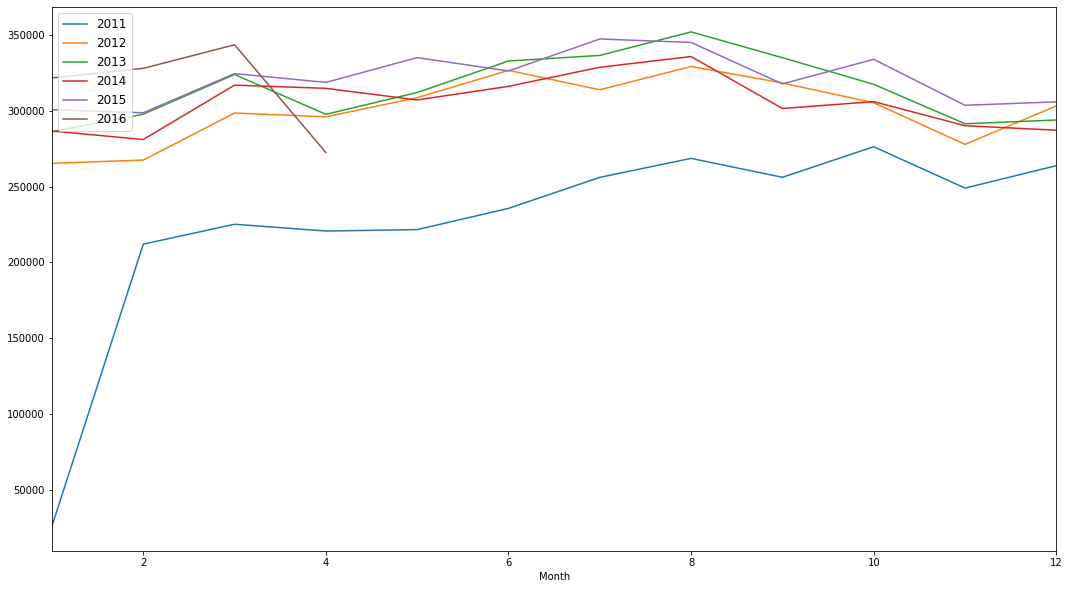

In [12]:
seasonalplot(texas)

In [13]:
def subseriesboxplot(df):
    data=df[['year','date','sales']]
    dfgr = data.groupby(['date'])['sales'].sum().reset_index()
    dfgr['month'] = pd.DatetimeIndex(dfgr['date']).month
    
    plt.figure(figsize=(18,10))
    ax = sns.boxplot(x='month',y='sales',data=dfgr)
    print(dfgr['sales'].describe())
    
    

count     1913.000000
mean      9879.250392
std       1964.928938
min          2.000000
25%       8608.000000
50%       9647.000000
75%      11171.000000
max      18733.000000
Name: sales, dtype: float64


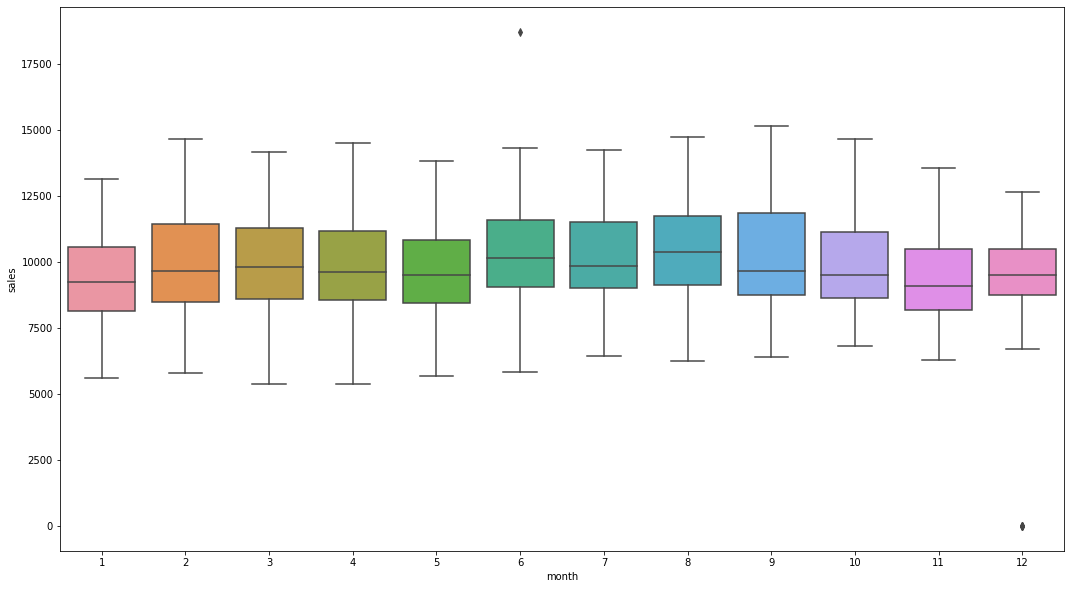

In [14]:
subseriesboxplot(texas)

In [15]:
def scatterbyday(df):
    data=df[['year','date','sales']]
    data['dayofyear'] = pd.DatetimeIndex(data['date']).dayofyear
    
    for y in list(data['year'].drop_duplicates()):
        dfgr = data[data['year']==y]
        dfgr = dfgr.groupby(['dayofyear'])['sales'].sum()
        dfgr.plot(figsize=(18,10))
    plt.legend(list(data['year'].drop_duplicates()),fontsize=12,loc='upper left')
    plt.show()
    
    dayofyear = data.groupby(['dayofyear'])['sales'].sum()
    dayofyear.plot(figsize=(18,10))

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


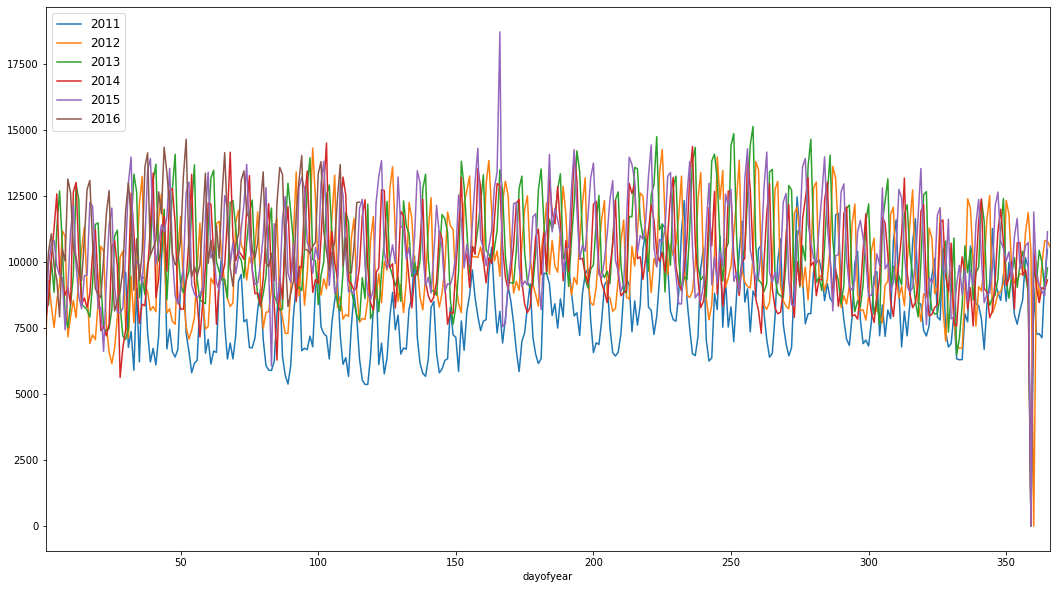

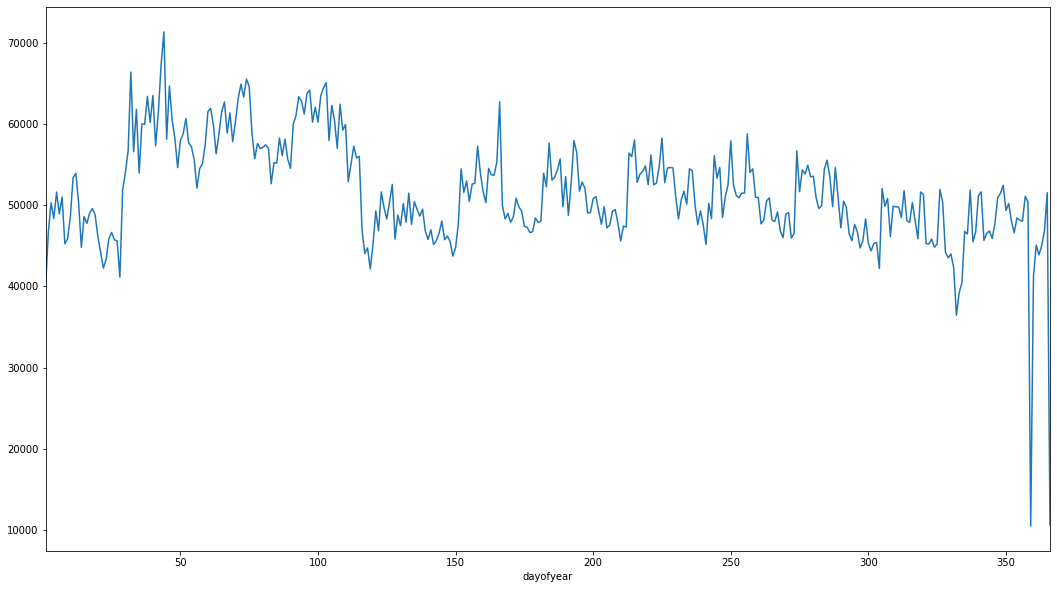

In [16]:
scatterbyday(texas)

## Autocorrelation

just as correlation emasures the extent of a linear relationship between two variables, the autocorrelation measures the linear relationship between lagged values of a time series. 

$$ rk = \frac {\sum^T_{t=k+1} (y_t - ybar) (y_{t-k}-ybar)}{\sum^T_{t=1}(y_t - ybar)^2} $$

In [17]:
autcorr= texas.groupby(['date'])['sales'].sum().reset_index()

In [18]:
def autocorrelation(x, n_lags):
    autocorrels = {'lags':[],'autocorrelation':[]}
    for l in range(1,n_lags):
        mean = x.mean()
        normarray = x[:-l]
        lagarray= x[l:]
        numerator = sum([((yt-mean)*(ytk-mean)) for yt,ytk in zip(normarray,lagarray)])
        denominator = sum([(yt-mean)**2 for yt in normarray])
        
        autocorrels['lags'].append(l)
        autocorrels['autocorrelation'].append(numerator/denominator)
        
        plt.vlines(l,0,(numerator/denominator))
         
    plt.plot(autocorrels['lags'],autocorrels['autocorrelation'],'bo')
    plt.hlines(0,0,n_lags+1)
    upperlimit = 2/np.sqrt(len(normarray))
    lowerlimit = -(2/np.sqrt(len(normarray)))
    plt.hlines(lowerlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.hlines(upperlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.show()


    return autocorrels


In [19]:
#### there appears to be a weekly seasonal component based on the autocorrelation graph. r5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday

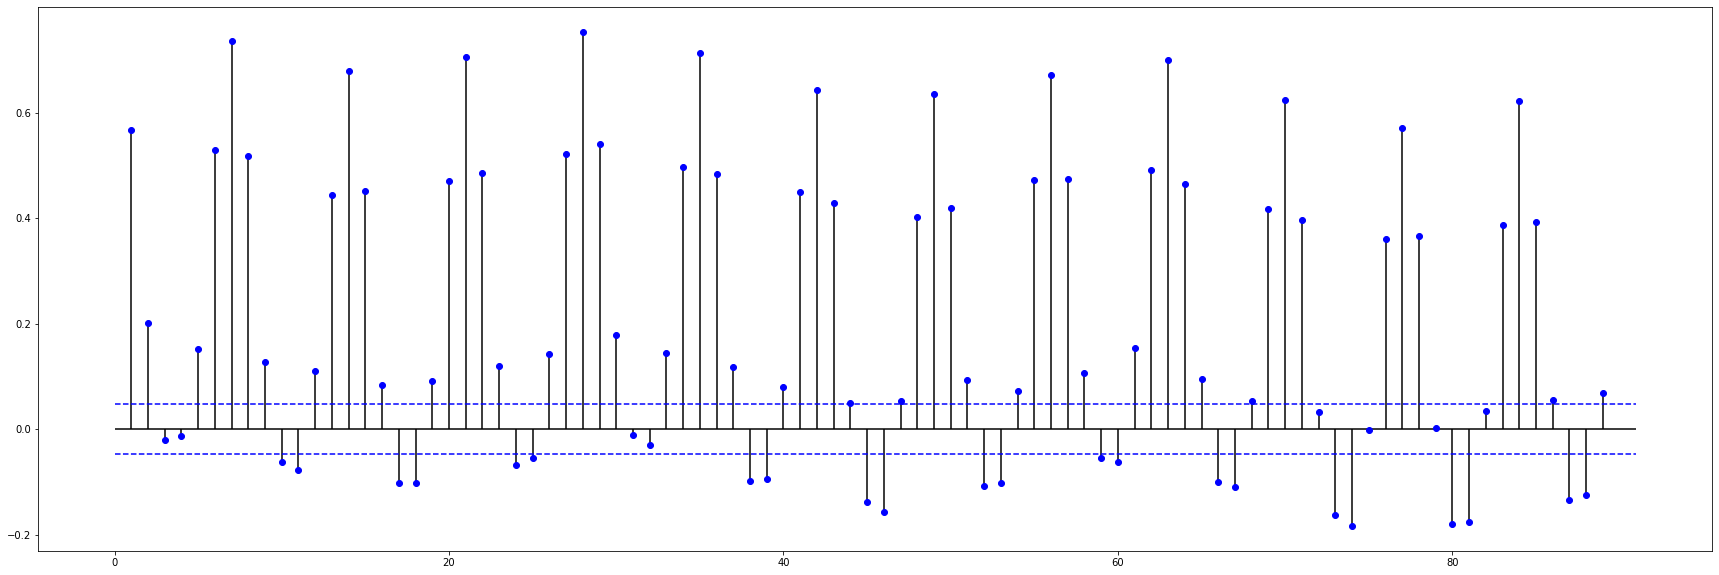

There appears to be a weekly seasonal component based on the autocorrelation graph. 
R5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday


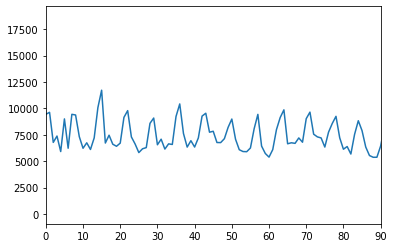

In [20]:

plt.figure(figsize=(30,10))
autocdf=autocorrelation(autcorr['sales'],n_lags=90)


plt.plot(autcorr['sales'])
plt.xlim(0,90)


print(

"There appears to be a weekly seasonal component based on the autocorrelation graph. \nR5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday"
)

A slow decrease in the ACF as lags increase is due to an upward trend while a slow increase would be due to a 
downward trend. Our time series does not appear to have any sort of trend.

## Noise

For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. For a white noise series, we expect 95% of the spikes in the ACF to lie within  ±2/√T where  T is the length of the time series. It is common to plot these bounds on a graph of the ACF as seen above with the dashed blue lines. If one or more large spikes ar eoutside of these bounds, or if substantially more than 5% of the spikes are outside, then the series is probably not noise. 

## Simple Forecasting Methods

    1.) Average Method: Forecasts for all future values are euqal to the average of the historical data. 
    
$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$
    
    2.) Naiive method
    3.) Seasonal Naiive Method
    4.) Drift Method

In [21]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales,d,wday,wm_yr_wk,event_name_1,date,year
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,1,11101,NaN,2011-01-29,2011
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,1,11101,NaN,2011-01-29,2011
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,1,11101,NaN,2011-01-29,2011
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,1,11101,NaN,2011-01-29,2011
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,1,11101,NaN,2011-01-29,2011


In [22]:
samplesub = pd.read_csv(path+'sample_submission.csv')

In [23]:
averageforcast = train_df.groupby(['id'])['sales'].mean().reset_index()

In [24]:
train = train_df[train_df['date']<='2016-04-01']
validation = train_df[train_df['date']>'2016-04-01']

<br>

<br>

Simple Average

$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$



In [73]:

def simplemean(train,validation):
    simplemean = train.groupby(['id'])['sales'].mean().reset_index()
    simplemean.columns= ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],simplemean,on='id')
    evaluate['residuals'] = evaluate['sales']-evaluate['predictedsales']
 
    
  
    
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    print("RMSE is {}".format(rmse))
    
    groupedevaldrft = evaluate.groupby(['date'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date'])['sales'].sum().reset_index()
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date')

    trained = train.groupby(['date'])['sales'].sum().reset_index()


    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
    
    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')
    


    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt((1+(1/len(grouped))))
    grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt((1+(1/len(grouped))))
    
    grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt((1+(1/len(grouped))))
    grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt((1+(1/len(grouped))))
    
    
    
    
    
    plt.figure(figsize=(18,5))

    plt.plot(trained['date'],trained['sales'])
    plt.plot(grouped['date'],grouped['sales'])
    plt.plot(grouped['date'],grouped['predictedsales'])
    
    plt.plot(grouped['date'],grouped['upper95'],'b')
    plt.plot(grouped['date'],grouped['lower95'],'b')
    plt.plot(grouped['date'],grouped['upper80'],'b--',)
    plt.plot(grouped['date'],grouped['lower80'],'b--')
    
    plt.fill_between(grouped['date'], 
                     grouped['predictedsales'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['predictedsales'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')




    plt.xlim('2016-01-01','2016-04-26')


    
    

    return rmse


RMSE is 2.606875306758872


2.606875306758872

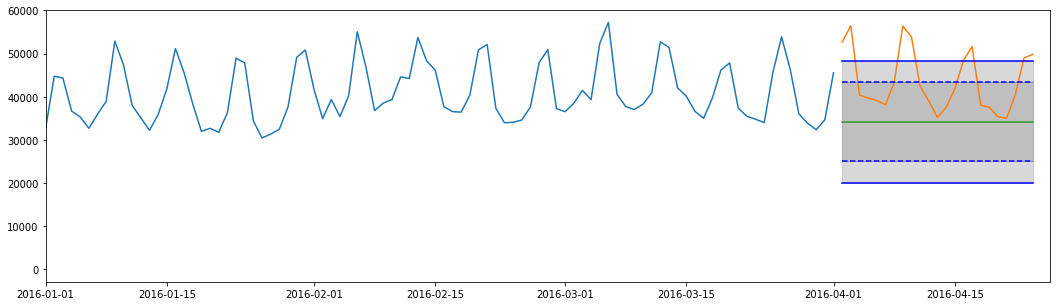

In [74]:
simplemean(train,validation)

$$ Naiive Method $$
$$ yhat_{T+h|T}=y_T $$

#simply set all forecasts to be the value of the last observation

In [68]:
def naiveforecast(train,validation):
    maxdate = train['date'].max()
    maxdatedf = train[train['date']==maxdate]
    maxdatedf=maxdatedf[['id','sales']]
    maxdatedf.columns = ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],maxdatedf,on='id')
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    
    print("RMSE is {}".format(rmse))
    
    groupedevaldrft = evaluate.groupby(['date'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date'])['sales'].sum().reset_index()
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date')

    trained = train.groupby(['date'])['sales'].sum().reset_index()


    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
    
    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')
    


    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt(grouped['h'])
    grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt(grouped['h'])
    
    grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt(grouped['h'])
    grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt(grouped['h'])
    
    
    
    
    
    plt.figure(figsize=(18,5))

    plt.plot(trained['date'],trained['sales'])
    plt.plot(grouped['date'],grouped['sales'])
    plt.plot(grouped['date'],grouped['predictedsales'])
    
    plt.plot(grouped['date'],grouped['upper95'],'b')
    plt.plot(grouped['date'],grouped['lower95'],'b')
    plt.plot(grouped['date'],grouped['upper80'],'b--',)
    plt.plot(grouped['date'],grouped['lower80'],'b--')
    
    plt.fill_between(grouped['date'], 
                     grouped['predictedsales'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['predictedsales'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')




    plt.xlim('2016-01-01','2016-04-26')

  
    return rmse

RMSE is 2.8196461243469866


2.8196461243469866

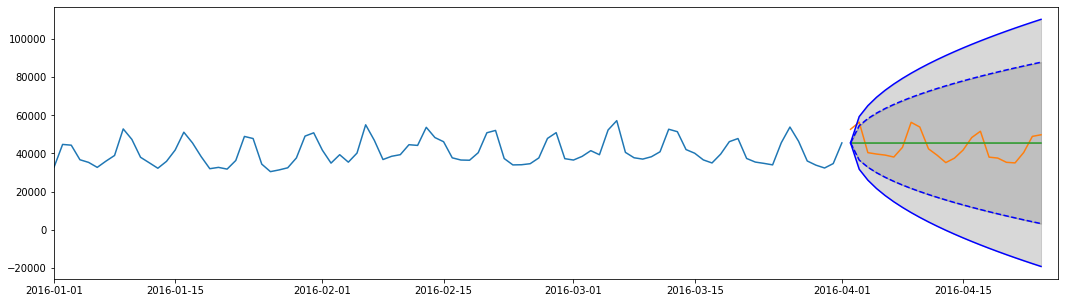

In [69]:
naiveforecast(train,validation)

We set each forecast to be equal to the last observation value from the same point on time of the year before

$$ Seasonal Naiive Method $$
$$ yhat_{T+h|T} = y_{T+h - m(k+1)} $$

Where m is the seasonal period and k is the ineger part of (h-1)/m 
With quarterly data, the forecast of all future Q2 values is equal to the last observed Q2

In [77]:
def seasonalnaiveforecast(train,validation):
    validation['date']= pd.to_datetime(validation['date'])
    train['date']= pd.to_datetime(train['date'])


    validation = validation[['id','sales','date']]
    validation['t-1'] = validation['date']- pd.Timedelta(days=365) 
    seasonal = train[['id','date','sales']]
    seasonal.columns = ['id','date','predictedsales']
    evaluate = pd.merge(validation,seasonal,left_on=['id','t-1'],
                       right_on=['id','date'])
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    print("RMSE is {}".format(rmse))
    
    
    forecastdays = pd.DataFrame({'days':validation['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]


    groupedevaldrft = evaluate.groupby(['date_x'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date_x'])['sales'].sum().reset_index()
    
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date_x')

    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    
    grouped = pd.merge(grouped,forecastdays,left_on='date_x',right_on='days')
    


    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt((grouped['h']-1)/7)
    grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt((grouped['h']-1)/7)
    grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt((grouped['h']-1)/7)
    grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt((grouped['h']-1)/7)
    
    
   
    plt.figure(figsize=(18,5))

    plt.plot(trained['date'],trained['sales'])
    
    
    
    plt.plot(grouped['date_x'],grouped['sales'])
    plt.plot(grouped['date_x'],grouped['predictedsales'])
    
    plt.plot(grouped['date_x'],grouped['upper95'],'b')
    plt.plot(grouped['date_x'],grouped['lower95'],'b')
    plt.plot(grouped['date_x'],grouped['upper80'],'b--',)
    plt.plot(grouped['date_x'],grouped['lower80'],'b--')
    
    plt.xlim('2016-01-01','2016-04-26')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['predictedsales'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['predictedsales'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date_x'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')




    plt.xlim('2016-01-01','2016-04-26')
    






    return rmse

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

RMSE is 3.2746967098501307


/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


3.2746967098501307

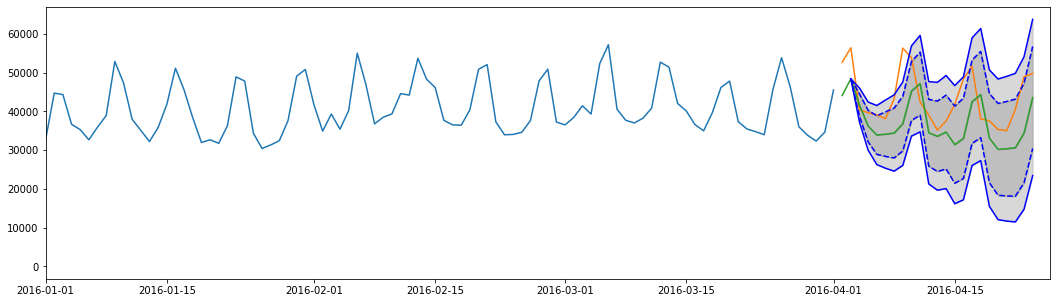

In [78]:
seasonalnaiveforecast(train,validation)

### Drift Method
    -A variation of the naiive method is to allow forecast to increase or decrease over time, where the amount
    
    of the change over time (the *drift*) is set to be the average change seen in the historical data.
    
$$ yhat_{T+h|T} = y_T + h\frac{y_t - y_1}{T - T_0}$$ 

In [84]:

def driftmethodforecast(train,validation):
    
    
    y_t_df = train[train['date']==train['date'].max()][['id','sales']]
    y_0_df = train[train['date']==train['date'].min()][['id','sales']]
    y_t_df.columns=['id','salesT']
    y_0_df.columns=['id','sales0']
    valcounts = train['id'].value_counts().reset_index()
    valcounts.columns=['id','counts']

    m_df = pd.merge(pd.merge(y_t_df,y_0_df,on='id'),valcounts,on='id')
    m_df['slope'] = (m_df['salesT']-m_df['sales0'])/m_df['counts']


    forecastdays = pd.DataFrame({'days':validation['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]

    evaluationdf = pd.merge(validation[['id','date','sales']],forecastdays,left_on='date',right_on='days')

    evaluationdf = pd.merge(evaluationdf,m_df,on='id')


    evaluationdf['drift_forecast'] = evaluationdf['salesT'] + (evaluationdf['slope'] * evaluationdf['h'])
    
    

    rmse= np.sqrt(mean_squared_error(evaluationdf['sales'],evaluationdf['drift_forecast']))

    print("RMSE is {}".format(rmse))



    groupedevaldrft = evaluationdf.groupby(['date'])['drift_forecast'].sum().reset_index()
    groupedevalsales = evaluationdf.groupby(['date'])['sales'].sum().reset_index()
    
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    
    
 
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,left_on='date',right_on='date')
    
    
    grouped['residuals'] = grouped['sales']-grouped['drift_forecast']
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
    
    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')

    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['drift_forecast'] + (1.96*stdv) *np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    grouped['lower95'] = grouped['drift_forecast'] - (1.96*stdv) *np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    
    grouped['upper80'] = grouped['drift_forecast'] + (1.28*stdv)*np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    grouped['lower80'] = grouped['drift_forecast'] - (1.28*stdv)*np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    

    plt.figure(figsize=(18,5))
    plt.plot(grouped['date'],grouped['sales'])
    plt.plot(trained['date'],trained['sales'])
    plt.plot(grouped['date'],grouped['drift_forecast'])
    
    
    
    plt.plot(grouped['date'],grouped['upper95'],'b')
    plt.plot(grouped['date'],grouped['lower95'],'b')
    plt.plot(grouped['date'],grouped['upper80'],'b--',)
    plt.plot(grouped['date'],grouped['lower80'],'b--')
    
    plt.fill_between(grouped['date'], 
                     grouped['drift_forecast'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['drift_forecast'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')





    plt.xlim('2016-01-01','2016-04-26')




    
    return rmse

RMSE is 2.827786180120419


2.827786180120419

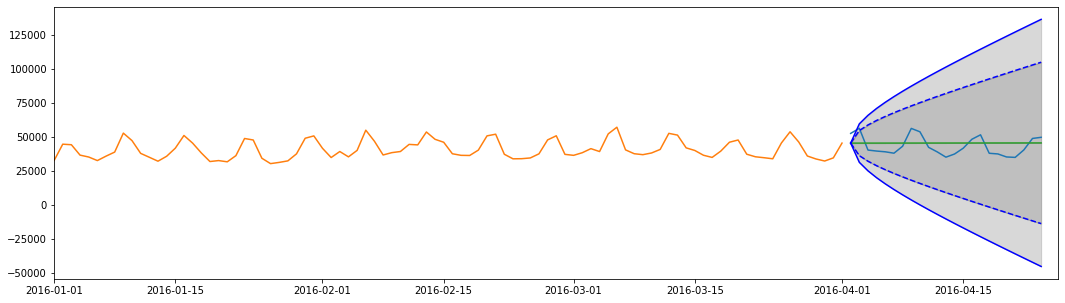

In [85]:
driftmethodforecast(train,validation)